In [1]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor
from tqdm.auto import tqdm, trange

from utils.plotting import plot_results, show_metrics, save_metrics
from models.pytorch_vit import VisionTransformerGrayscale
from models.brian_puffer_vit import MyViT

### Parameters for the models

In [2]:
num_layers = 6
num_heads = 6
hidden_dim = 30
mlp_dim = 30
num_classes = 10
dropout = 0.1

N_EPOCHS = 3
LR = 5e-3

# Training and Testing

### Load Dataset and initialize metrics

In [3]:
# Metrics
train_loss_metric = []
train_accuracy_metric = []
test_loss_metric = []
test_accuracy_metric = []

# Loading data
transform = ToTensor()

train_set = MNIST(root="./../datasets", train=True, download=True, transform=transform)
test_set = MNIST(root="./../datasets", train=False, download=True, transform=transform)

print(f"Train set size: {len(train_set)} and Test set size: {len(test_set)}")

# train_set = torch.utils.data.Subset(train_set, range(0, 1000))
# test_set = torch.utils.data.Subset(test_set, range(0, 100))

train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

# Defining model and training options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(
    "Using device: ",
    device,
    f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "",
)

Train set size: 60000 and Test set size: 10000
Using device:  cuda (NVIDIA GeForce RTX 3080 Ti)


### Choose model to train

In [4]:
# model = MyViT(
#     (1, 28, 28),
#     n_patches=7,
#     n_blocks=num_layers,
#     hidden_d=hidden_dim,
#     n_heads=num_heads,
#     out_d=10,
# ).to(device)

model = VisionTransformerGrayscale(
    num_layers=num_layers,
    num_heads=num_heads,
    hidden_dim=hidden_dim,
    mlp_dim=mlp_dim,
    num_classes=num_classes,
    dropout=dropout,
).to(device)

### Training/Testing Loop

In [5]:
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()

for epoch in trange(N_EPOCHS, desc="Training"):
    correct, total = 0, 0
    train_loss = 0.0
    # Train
    for batch in tqdm(
        train_loader, desc=f"Epoch {epoch + 1} in training", leave=False, miniters=1
    ):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)
        # print(f"\n\nTrain Loss: {train_loss}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
        # print(f"[TRAIN] We have {correct} corrects and {total} total")

    print(
        f"Epoch {epoch + 1}/{N_EPOCHS} \nTrain loss: {train_loss:.2f}, Train accuracy: {correct / total * 100:.2f}%"
    )

    train_loss_metric.append(train_loss)
    train_accuracy_metric.append(correct / total * 100)

    # Test
    with torch.no_grad():
        correct_test, total_test = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            test_loss += loss.detach().cpu().item() / len(test_loader)
            correct_test += (
                torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            )
            total_test += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct_test / total_test * 100:.2f}%")
        # print(f"[TEST] We have {correct_test} corrects and {total_test} total")
    test_loss_metric.append(test_loss)
    test_accuracy_metric.append(correct_test / total_test * 100)

save_metrics(
    num_layers,
    num_heads,
    hidden_dim,
    mlp_dim,
    N_EPOCHS,
    LR,
    train_accuracy_metric,
    test_accuracy_metric,
    train_loss_metric,
    test_loss_metric
)

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/3 
Train loss: 1.00, Train accuracy: 64.52%


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 0.35
Test accuracy: 89.69%


Epoch 2 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/3 
Train loss: 0.31, Train accuracy: 90.54%


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 0.24
Test accuracy: 92.68%


Epoch 3 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/3 
Train loss: 0.22, Train accuracy: 93.15%


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 0.19
Test accuracy: 93.85%


# Plotting

### Plotting a specific file/run

{'num_layers': 6, 'num_heads': 6, 'hidden_dim': 30, 'mlp_dim': 30, 'N_EPOCHS': 3, 'LR': 0.005}
Train accuracy:  93.15 Train loss:  0.2224036158560943
Test accuracy:  93.85 Test loss:  0.1884526860063212


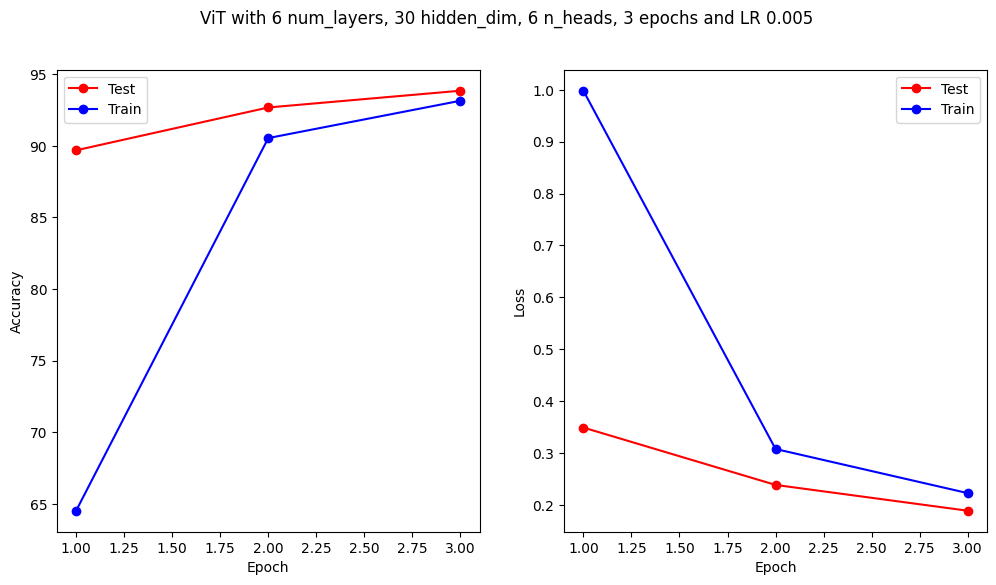

In [11]:
show_metrics("./metrics/23-11-06_01-54-17_metrics.npz")

### Plotting from current run

Train accuracy:  93.15 Train loss:  0.2224036158560943
Test accuracy:  93.85 Test loss:  0.1884526860063212


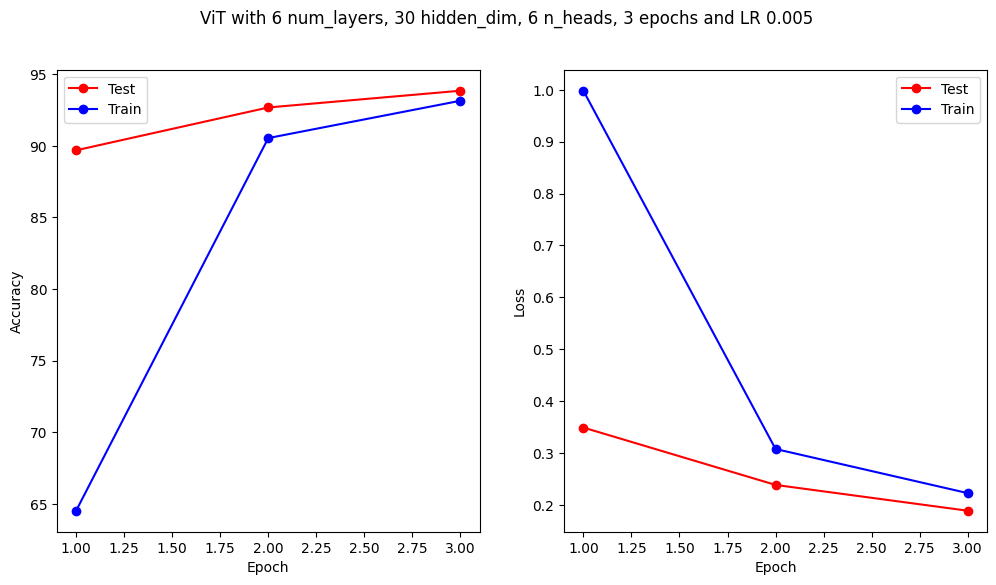

In [9]:
plot_results(num_layers, num_heads, hidden_dim, N_EPOCHS, LR, test_accuracy_metric, train_accuracy_metric, test_loss_metric, train_loss_metric)
print("Train accuracy: ", train_accuracy_metric[-1], "Train loss: ", train_loss_metric[-1])
print("Test accuracy: ", test_accuracy_metric[-1], "Test loss: ", test_loss_metric[-1])